In [ ]:

import numpy as np 
import pandas as pd 
import tensorflow as tf
import os

In [3]:
Data_Train ="datset\\Training"
Data_Test ="datset\\Testing"

In [4]:
import os
from pathlib import Path
def load(train_path,test_path):
    dict1=[]
    dict_test=[]
    class_names = ["glioma", "meningioma", "notumor", "pituitary"]
    for label in class_names:
        folder_path = os.path.join(train_path, label)
        for file_name in os.listdir(folder_path):
            dict1.append([label,os.path.join(folder_path, file_name)])

    for label in class_names:
        folder_path = os.path.join(test_path, label)
        for file_name in os.listdir(folder_path):
            dict_test.append([label,os.path.join(folder_path, file_name)])

    return pd.DataFrame(dict1, columns=['Label', 'Image_Path']),pd.DataFrame(dict_test, columns=['Label', 'Image_Path'])

In [5]:
df_Tr,df_te=load(Data_Train,Data_Test)

In [6]:
df_Tr.head()

,Label,Image_Path
0,glioma,datset\Training\glioma\Tr-glTr_0000.jpg
1,glioma,datset\Training\glioma\Tr-glTr_0001.jpg
2,glioma,datset\Training\glioma\Tr-glTr_0002.jpg
3,glioma,datset\Training\glioma\Tr-glTr_0003.jpg
4,glioma,datset\Training\glioma\Tr-glTr_0004.jpg


In [7]:
df_te.head()

,Label,Image_Path
0,glioma,datset\Testing\glioma\Te-glTr_0000.jpg
1,glioma,datset\Testing\glioma\Te-glTr_0001.jpg
2,glioma,datset\Testing\glioma\Te-glTr_0002.jpg
3,glioma,datset\Testing\glioma\Te-glTr_0003.jpg
4,glioma,datset\Testing\glioma\Te-glTr_0004.jpg


C:\Users\cclab1\AppData\Local\Temp\ipykernel_139788\4044830713.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df_Tr["Label"], palette="viridis")


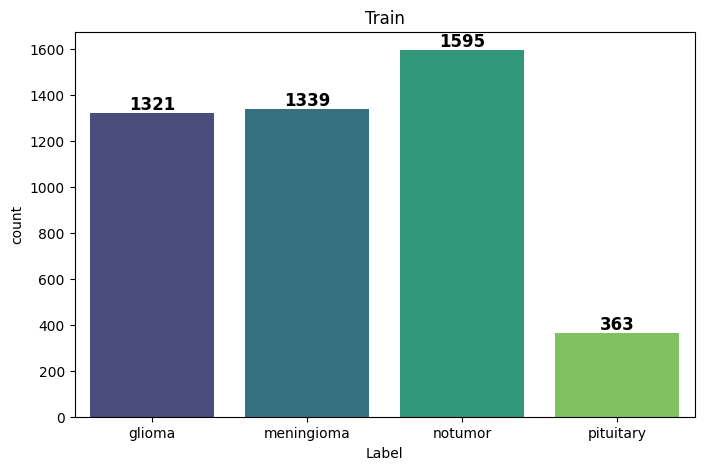

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=df_Tr["Label"], palette="viridis")

# Annotate count values on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.title('Train')
plt.show()


C:\Users\cclab1\AppData\Local\Temp\ipykernel_139788\3597689723.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df_te["Label"], palette="viridis")


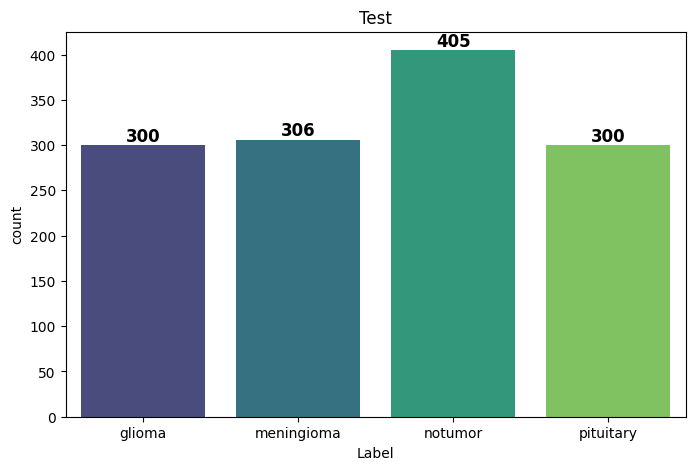

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=df_te["Label"], palette="viridis")

# Annotate count values on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.title('Test')
plt.show()

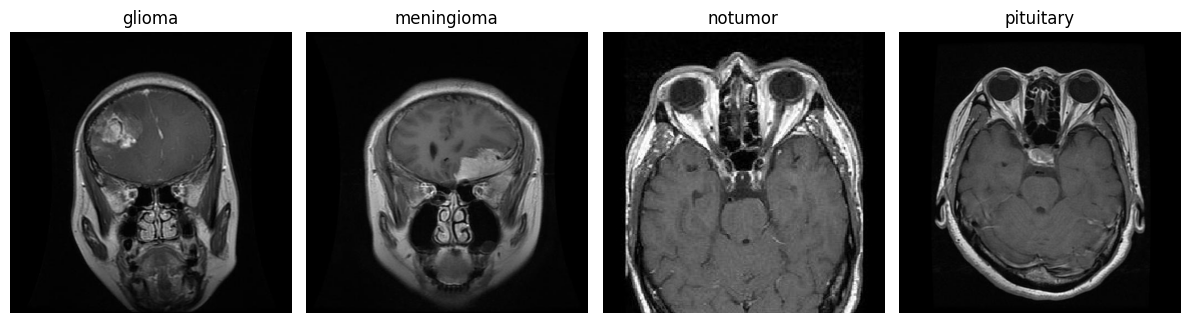

In [10]:
from PIL import Image

# Assuming df is already created
# Select one image per class
sample_images = df_Tr.groupby("Label").first().reset_index()

# Plot images
fig, axes = plt.subplots(1, len(sample_images), figsize=(12, 5))

for ax, (label, img_path) in zip(axes, zip(sample_images["Label"], sample_images["Image_Path"])):
    img = Image.open(img_path)  # Open image
    ax.imshow(img, cmap="gray")  # Show image
    ax.set_title(label)  # Set title as class name
    ax.axis("off")  # Hide axes

plt.tight_layout()
plt.show()


Converting into tenorflow format


In [11]:
train_dir = "datset\\Training"
test_dir = "datset\\Testing"

# Parameters for loading
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",  # Use "int" for integer labels
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

# Load testing dataset
full_test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

# Calculate the number of validation samples (50% of the testing data)
test_dataset_size = len(full_test_ds)
val_size = test_dataset_size // 2

# Split the dataset into validation and testing sets
val_ds = full_test_ds.take(val_size)  # Take the first 50% for validation
test_ds = full_test_ds.skip(val_size)  # Skip the first 50% for testing

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Model


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_brain_tumor_cnn(input_shape=(180, 180, 3), num_classes=4):
    model = models.Sequential()
    
    # First convolutional block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    # Second convolutional block
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    # Third convolutional block
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    # Fourth convolutional block
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    # Flatten and dense layers
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Create the model
model = create_brain_tumor_cnn()

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 89, 89, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 43, 43, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,009,732 (42.00 MB)

 Trainable params: 11,008,772 (42.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10  # Adjust based on your needs
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 129s 705ms/step - accuracy: 0.6894 - loss: 1.6634 - val_accuracy: 0.3234 - val_loss: 2.1674
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 119s 663ms/step - accuracy: 0.8291 - loss: 0.4911 - val_accuracy: 0.2078 - val_loss: 4.4775
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 123s 683ms/step - accuracy: 0.8874 - loss: 0.3196 - val_accuracy: 0.7516 - val_loss: 0.6331
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 125s 696ms/step - accuracy: 0.9286 - loss: 0.1945 - val_accuracy: 0.7234 - val_loss: 0.7823
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 121s 673ms/step - accuracy: 0.9374 - loss: 0.1636 - val_accuracy: 0.8250 - val_loss: 0.5958
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 123s 688ms/step - accuracy: 0.9565 - loss: 0.1368 - val_accuracy: 0.8313 - val_loss: 0.5284
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 124s 694ms/step - accuracy: 0.9647 - loss: 0.1050 - val_accuracy: 0.4437 - val_loss: 11.2941
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 119s 661ms/step - accuracy: 0.9532 

In [18]:
model.save("SIMPLE_CNN.keras")

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Get the class names (based on your dataset structure)
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Step 1: Extract true labels from test_ds
# Note: We need to collect all batches as test_ds is batched
true_labels = []
for images, labels in test_ds:
    true_labels.extend(np.argmax(labels, axis=1))
true_labels = np.array(true_labels)

# Step 2: Get predictions from model
all_predictions = []
for images, _ in test_ds:
    batch_predictions = model.predict(images)
    all_predictions.extend(np.argmax(batch_predictions, axis=1))
predicted_labels = np.array(all_predictions)

# Step 3: Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Step 4: Generate a detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Step 5: Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(cm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Accuracy: 0.9955

Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00         0
  meningioma       0.00      0.

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Now Doing Augementation

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2, # Shift width
    # height_shift_range=0.2,# Shift height
    shear_range=0.2,       # Shear transformation
    zoom_range=0.2,        # Zoom
    horizontal_flip=True,  # Flip images
)

train_generator = train_datagen.flow_from_directory(
    "datset\\Training",
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical'  # or 'binary' for binary classification
)

Found 5712 images belonging to 4 classes.


Text(0.5, 1.0, 'Label: meningioma')

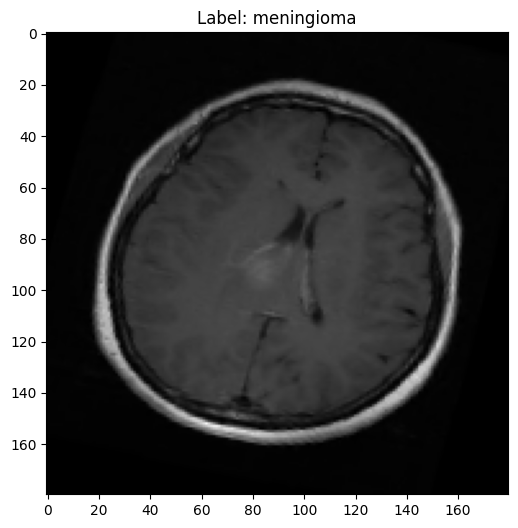

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Get class labels from the generator
class_names = list(train_generator.class_indices.keys())  # Get class labels

# Get a batch of augmented images and labels
images, labels = next(train_generator)  # Fetch one batch (32 images)

# Plot 6 random augmented images with labels
plt.figure(figsize=(10, 6))
single_img=images[0]
label_index = np.argmax(labels[0])
plt.imshow(single_img)

plt.title(f"Label: {class_names[label_index]}")

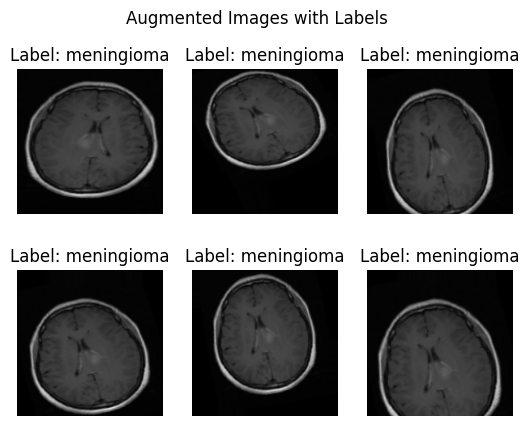

In [22]:
for i in range(6):
    aug=train_datagen.random_transform(single_img)
    plt.subplot(2, 3, i + 1)
    plt.imshow( aug)  # Display the image
    plt.axis("off")
    
    # Convert one-hot encoded label back to class name
      # Get index of max value (class index)
    plt.title(f"Label: {class_names[label_index]}")

plt.suptitle("Augmented Images with Labels")
plt.show()

In [90]:
test_datagen = ImageDataGenerator(rescale=1./255)  

# Load Test Data
test_generator = test_datagen.flow_from_directory(
    "datset/Testing",  # Path to test dataset
    target_size=(180, 180),  
    batch_size=1,  
    class_mode='categorical',  # Change to 'binary' if only 2 classes
    shuffle=False  # Do not shuffle test data
)

# Print class labels
print("Test class labels:", test_generator.class_indices)

Found 165 images belonging to 4 classes.
Test class labels: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_brain_tumor_cnn(input_shape=(180, 180, 3), num_classes=4):
    model = models.Sequential()
    
    # First convolutional block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    # Second convolutional block
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    # Third convolutional block
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    # Fourth convolutional block
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    # Flatten and dense layers
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Create the model
model = create_brain_tumor_cnn()

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 89, 89, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 43, 43, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,009,732 (42.00 MB)

 Trainable params: 11,008,772 (42.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [27]:
model.save("SIMPLE_CNN_AUGMENT.keras")

In [28]:
img,label=next(train_generator)

In [29]:
train_generator.samples

5712

In [30]:
len(train_generator)

179

In [31]:
train_generator.batch_size

32

In [32]:
spe=len(train_generator)

In [33]:
import math

steps_per_epoch = math.ceil(5712 / 32)  # Ensures all data is used (179 steps)
hi=model.fit(
    train_generator,
    epochs=10,
)

c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 127s 696ms/step - accuracy: 0.5607 - loss: 1.9743
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 122s 681ms/step - accuracy: 0.7033 - loss: 0.7689
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 123s 688ms/step - accuracy: 0.7494 - loss: 0.6673
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 123s 687ms/step - accuracy: 0.7771 - loss: 0.6475
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 125s 695ms/step - accuracy: 0.8118 - loss: 0.5033
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 126s 703ms/step - accuracy: 0.8182 - loss: 0.4761
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 125s 695ms/step - accuracy: 0.8299 - loss: 0.4700
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 123s 687ms/step - accuracy: 0.8587 - loss: 0.4006
Epoch 9/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 125s 698ms/step - accuracy: 0.8762 - loss: 0.3445
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 128s 713ms/step - accuracy: 0.8688 - loss: 0.3551


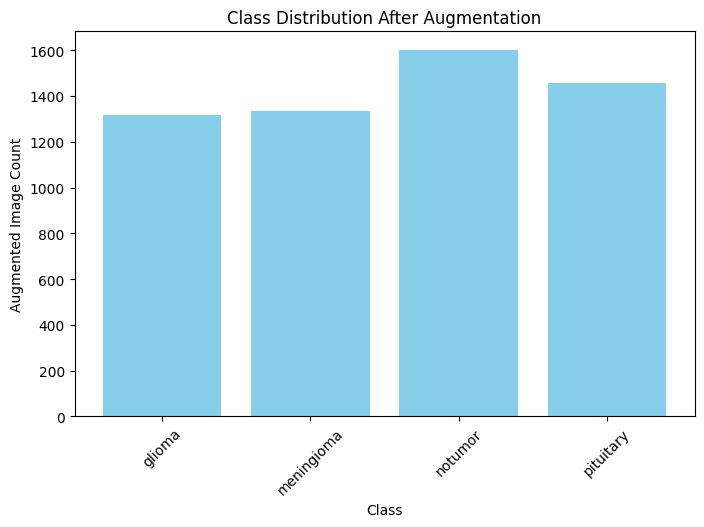

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Get class indices mapping
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}  # Reverse mapping

# Initialize class counts
class_counts = Counter()

# Iterate through the generator to count occurrences
num_batches = len(train_generator)
for i in range(num_batches):
    images, labels = next(train_generator)
    label_indices = np.argmax(labels, axis=1)  # Convert one-hot to class indices
    class_counts.update(label_indices)

# Convert indices to class names
class_names = [class_labels[i] for i in sorted(class_counts.keys())]
counts = [class_counts[i] for i in sorted(class_counts.keys())]

# Plot the class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_names, counts, color="skyblue")
plt.xlabel("Class")
plt.ylabel("Augmented Image Count")
plt.title("Class Distribution After Augmentation")
plt.xticks(rotation=45)
plt.show()

In [91]:
batch_x, batch_y = next(iter(test_generator))

In [92]:
batch_x.shape

(1, 180, 180, 3)

In [143]:
true_labels = []
true_img = []
ans=0
for i in range(len(test_generator)):
    # for images in batch_x:
    true_img.append(np.squeeze(test_generator[i][0], axis=0))
    ans+=1
    # for labels in batch_y:
    true_labels.append(int(np.argmax(test_generator[i][1])))

In [145]:
real_ans=[]
for i in range(len(true_labels)):
    real_ans.append([true_img[i],true_labels[i]])

In [146]:
import random

In [147]:
random.shuffle(real_ans)

In [148]:
true_img[0].shape

(180, 180, 3)

In [152]:
all_predictions = []
for i in range(len(real_ans)):
    batch_predictions = model.predict(np.expand_dims(real_ans[i][0], axis=0))[0]
    all_predictions.append(int(np.argmax(batch_predictions)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

In [153]:
predicted_labels = np.array(all_predictions)

In [154]:
predicted_labels

array([2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2,
       2, 1, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 3, 0, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 3, 3, 2, 2,
       2, 3, 2, 3, 2, 2, 0, 2, 0, 2, 3, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 1,
       2, 0, 2, 2, 2, 0, 0, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2])

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Get the class names (based on your dataset structure)
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Step 1: Extract true labels from test_ds
# Note: We need to collect all batches as test_ds is batched
true_labels = []
for images, labels in test_generator:
    true_labels.extend(np.argmax(labels, axis=1))
true_labels = np.array(true_labels)

# Step 2: Get predictions from model
all_predictions = []
for images, _ in test_generator:
    batch_predictions = model.predict(images)
    all_predictions.extend(np.argmax(batch_predictions, axis=1))
predicted_labels = np.array(all_predictions)


In [155]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']


In [156]:
class_labels

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

In [157]:
true_labels=[]
for lbl in real_ans:
    true_labels.append(lbl[1])

In [159]:

# Step 3: Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Step 4: Generate a detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names,
    labels=[0, 1, 2, 3] ))

# Step 5: Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(cm)

Accuracy: 0.5273

Classification Report:
              precision    recall  f1-score   support

      glioma       0.59      0.29      0.38        35
  meningioma       1.00      0.11      0.20        44
     notumor       0.47      1.00      0.64        57
   pituitary       0.68      0.52      0.59        29

    accuracy                           0.53       165
   macro avg       0.69      0.48      0.45       165
weighted avg       0.67      0.53      0.46       165


Confusion Matrix:
[[10  0 25  0]
 [ 6  5 26  7]
 [ 0  0 57  0]
 [ 1  0 13 15]]


Transfer Learning

In [161]:
import os
import random
import shutil
from pathlib import Path

# Define paths
source_path = Path("datset\Training")  # Your current nested dataset structure
output_path = Path("data")             # Where to create train/validation split

# Define the split ratio (0.8 = 80% training, 20% validation)
train_ratio = 0.8

# Create output directories
train_dir = output_path / "train"
val_dir = output_path / "validation"

# Create the directory structure if it doesn't exist
for directory in [train_dir, val_dir]:
    directory.mkdir(parents=True, exist_ok=True)

    # Create class subdirectories
    for class_name in ["glioma", "meningioma", "notumor"]:
        (directory / class_name).mkdir(exist_ok=True)

# Function to split and copy files
def split_data():
    # Process each class
    for class_name in ["glioma", "meningioma", "notumor"]:
        # Get all image files from the class folder
        class_path = source_path / class_name
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Shuffle files for randomization
        random.shuffle(files)

        # Calculate split point
        split_idx = int(len(files) * train_ratio)

        # Split into training and validation sets
        train_files = files[:split_idx]
        val_files = files[split_idx:]

        # Copy training files
        for file in train_files:
            src = class_path / file
            dst = train_dir / class_name / file
            shutil.copy2(src, dst)
            print(f"Copied {file} to training set")

        # Copy validation files
        for file in val_files:
            src = class_path / file
            dst = val_dir / class_name / file
            shutil.copy2(src, dst)
            print(f"Copied {file} to validation set")

        print(f"Class {class_name}: {len(train_files)} training, {len(val_files)} validation images")

if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)

    # Execute the split
    print("Starting dataset split...")
    split_data()
    print("Dataset split complete!")
    print(f"Training data: {train_dir}")
    print(f"Validation data: {val_dir}")


<>:7: SyntaxWarning: invalid escape sequence '\T'
<>:7: SyntaxWarning: invalid escape sequence '\T'
C:\Users\cclab1\AppData\Local\Temp\ipykernel_139788\1901903805.py:7: SyntaxWarning: invalid escape sequence '\T'
  source_path = Path("datset\Training")  # Your current nested dataset structure


Starting dataset split...
Copied Tr-gl_0588.jpg to training set
Copied Tr-gl_1198.jpg to training set
Copied Tr-gl_0057.jpg to training set
Copied Tr-gl_1085.jpg to training set
Copied Tr-gl_1254.jpg to training set
Copied Tr-gl_0618.jpg to training set
Copied Tr-gl_0599.jpg to training set
Copied Tr-gl_0289.jpg to training set
Copied Tr-gl_0608.jpg to training set
Copied Tr-gl_0400.jpg to training set
Copied Tr-gl_0237.jpg to training set
Copied Tr-gl_0616.jpg to training set
Copied Tr-gl_0672.jpg to training set
Copied Tr-gl_1194.jpg to training set
Copied Tr-gl_0463.jpg to training set
Copied Tr-gl_0222.jpg to training set
Copied Tr-gl_1242.jpg to training set
Copied Tr-gl_0238.jpg to training set
Copied Tr-gl_0730.jpg to training set
Copied Tr-gl_0055.jpg to training set
Copied Tr-gl_0772.jpg to training set
Copied Tr-gl_0176.jpg to training set
Copied Tr-gl_0015.jpg to training set
Copied Tr-gl_0066.jpg to training set
Copied Tr-gl_0479.jpg to training set
Copied Tr-gl_1239.jpg to

In [162]:
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Configuration parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 3  # Adjust if you have a different number of classes
TRAIN_DIR = 'data/train'         # Folder structure: data/train/<class_name>
VALIDATION_DIR = 'data/validation' # Folder structure: data/validation/<class_name>

# Data preparation and augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)



In [163]:

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 3403 images belonging to 3 classes.
Found 852 images belonging to 3 classes.


In [164]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers to train only custom layers initially
base_model.trainable = False

# Add custom layers on top of the base model for our classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)             # Pool features to reduce dimensions
x = Dense(1024, activation='relu')(x)       # Fully connected layer with 1024 units
x = Dropout(0.5)(x)                         # Dropout layer to prevent overfitting
predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer for classification

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with an optimizer, loss function, and evaluation metric
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train only the new top layers (initial training)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,243,075 (58.15 MB)

 Trainable params: 528,387 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [165]:
initial_epochs = 10

history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=validation_generator,
)

# Fine-tuning: Unfreeze some layers of the base model to improve performance further.
for layer in base_model.layers[-10:]:  # Unfreeze last 10 layers of VGG16 base model.
    layer.trainable = True

# Re-compile with a lower learning rate for fine-tuning.
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_epochs = 10

history_fine_tune = model.fit(
    train_generator,
    epochs=initial_epochs + fine_tune_epochs,
    initial_epoch=initial_epochs,
    validation_data=validation_generator,
)

# Save the final model for later use.
model.save('brain_tumor_detection_vgg16.h5')

c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.6101 - loss: 0.8223 - val_accuracy: 0.8028 - val_loss: 0.4660
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.8113 - loss: 0.4574 - val_accuracy: 0.8451 - val_loss: 0.4087
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.8116 - loss: 0.4437 - val_accuracy: 0.8533 - val_loss: 0.4252
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.8230 - loss: 0.4435 - val_accuracy: 0.8650 - val_loss: 0.3749
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.8541 - loss: 0.3890 - val_accuracy: 0.8462 - val_loss: 0.3735
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.8633 - loss: 0.3572 - val_accuracy: 0.8803 - val_loss: 0.3217
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.8648 - loss: 0.3594 - val_accuracy: 0.8662 - val_loss: 0.3639
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 0.8731 - loss: 0.3338 - val_accu

BM3D FILTERING

In [167]:
import os
import cv2
import numpy as np
import bm3d

def denoise_image(img, sigma=30):
    """
    Denoise an image using the BM3D algorithm.
    
    Parameters:
      img (numpy.ndarray): Input image (assumed grayscale).
      sigma (float): The noise standard deviation (default 30).
    
    Returns:
      numpy.ndarray: Denoised image in uint8 format.
    """
    # Normalize image to [0, 1] as required by BM3D
    img_norm = img.astype(np.float32) / 255.0
    # BM3D parameters: sigma_psd should be sigma/255.
    denoised_img = bm3d.bm3d(img_norm, sigma_psd=sigma / 255.0, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    # Rescale back to [0, 255] and convert to uint8
    denoised_img = np.clip(denoised_img * 255, 0, 255).astype(np.uint8)
    return denoised_img


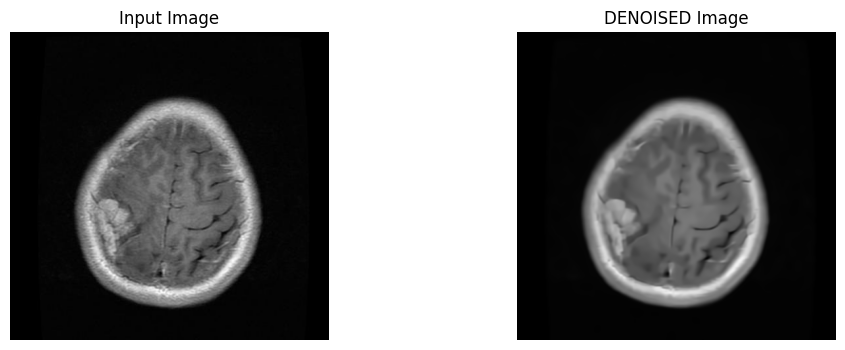

In [168]:

def show_denosing(img_path):
    img=cv2.imread(img_path)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    de=denoise_image(img)
    plt.subplot(1, 2, 2)
    plt.title("DENOISED Image")
    plt.imshow(de, cmap='gray')
    plt.axis('off')

show_denosing('image.png')

NOW CHECKING DOING TRAINING ON DENOISED DATASET

In [169]:
Data_Train ="final\\final"

In [170]:
import os
from pathlib import Path
def load(train_path):
    dict1=[]
    class_names = ["glioma", "meningioma", "notumor"]
    for label in class_names:
        folder_path = os.path.join(train_path, label)
        for file_name in os.listdir(folder_path):
            dict1.append([label,os.path.join(folder_path, file_name)])


    return pd.DataFrame(dict1, columns=['Label', 'Image_Path'])

In [171]:
df_Tr=load(Data_Train)

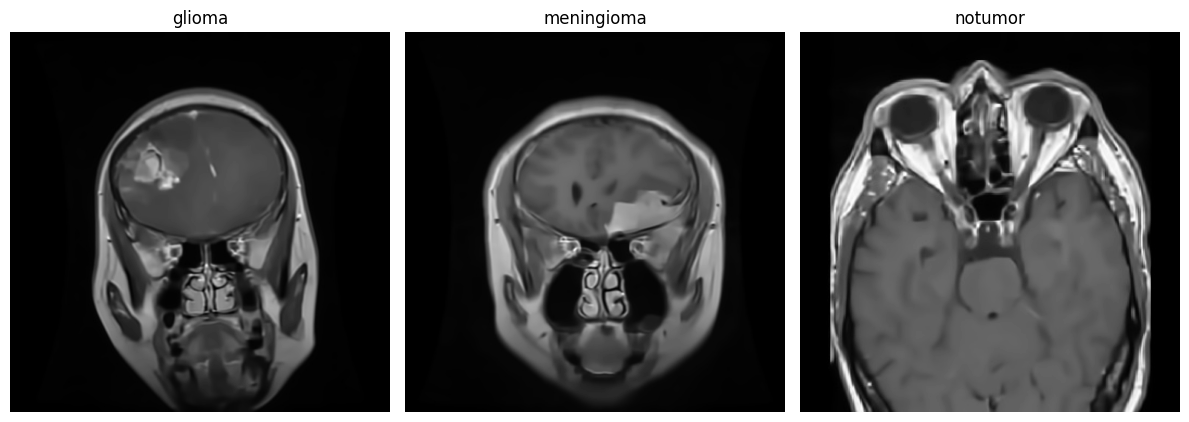

In [172]:
from PIL import Image

# Assuming df is already created
# Select one image per class
sample_images = df_Tr.groupby("Label").first().reset_index()

# Plot images
fig, axes = plt.subplots(1, len(sample_images), figsize=(12, 5))

for ax, (label, img_path) in zip(axes, zip(sample_images["Label"], sample_images["Image_Path"])):
    img = Image.open(img_path)  # Open image
    ax.imshow(img, cmap="gray")  # Show image
    ax.set_title(label)  # Set title as class name
    ax.axis("off")  # Hide axes

plt.tight_layout()
plt.show()

In [173]:
train_dir = "final\\final"

# Parameters for loading
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",  # Use "int" for integer labels
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

# Load testing dataset

# Calculate the number of validation samples (50% of the testing data)
test_dataset_size = len(train_ds)
val_size = test_dataset_size // 10

# Split the dataset into validation and testing sets
val_ds = train_ds.take(val_size)  # Take the first 50% for validation

Found 4243 files belonging to 3 classes.


In [174]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [175]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_brain_tumor_cnn(input_shape=(180, 180, 3), num_classes=3):
    model = models.Sequential()
    
    # First convolutional block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    # Second convolutional block
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    # Third convolutional block
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    # Fourth convolutional block
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    # Flatten and dense layers
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Create the model
model = create_brain_tumor_cnn()

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [176]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 89, 89, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 43, 43, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,009,219 (42.00 MB)

 Trainable params: 11,008,259 (41.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [177]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5  # Adjust based on your needs
)

Epoch 1/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 90s 646ms/step - accuracy: 0.6981 - loss: 1.9712 - val_accuracy: 0.3702 - val_loss: 3.1515
Epoch 2/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 86s 642ms/step - accuracy: 0.8425 - loss: 0.4032 - val_accuracy: 0.3942 - val_loss: 5.9540
Epoch 3/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 83s 622ms/step - accuracy: 0.8603 - loss: 0.4012 - val_accuracy: 0.8462 - val_loss: 0.4348
Epoch 4/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 83s 623ms/step - accuracy: 0.9061 - loss: 0.2346 - val_accuracy: 0.8053 - val_loss: 0.4919
Epoch 5/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 90s 674ms/step - accuracy: 0.9304 - loss: 0.1895 - val_accuracy: 0.8870 - val_loss: 0.3416


In [178]:
model.save("Denoised_BM3D_CNN.keras")

TUMOUR SEGMENTATION USING U-NET

In [ ]:
import os

import numpy as np
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [3]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [4]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [5]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:

# Conv Block
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x
# Encoder Block
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p
# Decoder Block/
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
# Build U-Net
def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

model = unet((256,256,3))
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [7]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [8]:
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir("files")

In [9]:
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [10]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

In [11]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [12]:
batch_size = 16
lr = 1e-4
num_epochs = 300
model_path = os.path.join("files", "BHAI_MERA_model.h5")
csv_path = os.path.join("files", "log.csv")
dataset_path="/content/dataset"

In [13]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: ({len(train_x)},{len(train_y)})")
print(f"Valid: ({len(valid_x)},{len(valid_x)})")
print(f"Test: ({len(test_x)},{len(test_x)})")

Train: (1840,1840)
Valid: (612,612)
Test: (612,612)


In [14]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [15]:
model = unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef,'accuracy'])

In [16]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

In [17]:
model.fit(
        train_dataset,
        epochs=12,
        validation_data=valid_dataset,
        callbacks=callbacks,
        verbose=0,
    )


Epoch 1: val_loss improved from inf to 0.97028, saving model to files/BHAI_MERA_model.h5



Epoch 2: val_loss did not improve from 0.97028

Epoch 3: val_loss did not improve from 0.97028

Epoch 4: val_loss improved from 0.97028 to 0.81272, saving model to files/BHAI_MERA_model.h5



Epoch 5: val_loss improved from 0.81272 to 0.57495, saving model to files/BHAI_MERA_model.h5



Epoch 6: val_loss improved from 0.57495 to 0.49555, saving model to files/BHAI_MERA_model.h5



Epoch 7: val_loss improved from 0.49555 to 0.38992, saving model to files/BHAI_MERA_model.h5



Epoch 8: val_loss improved from 0.38992 to 0.37021, saving model to files/BHAI_MERA_model.h5



Epoch 9: val_loss improved from 0.37021 to 0.36298, saving model to files/BHAI_MERA_model.h5



Epoch 10: val_loss improved from 0.36298 to 0.32220, saving model to files/BHAI_MERA_model.h5



Epoch 11: val_loss improved from 0.32220 to 0.31688, saving model to files/BHAI_MERA_model.h5



Epoch 12: val_loss improved from 0.31688 to 0.27646, saving model to files/BHAI_MERA_model.h5


In [20]:
import pandas as pd
metrics = pd.read_csv("/content/files/log.csv")
metrics.head()

,epoch,accuracy,dice_coef,learning_rate,loss,val_accuracy,val_dice_coef,val_loss
0,0,0.847049,0.143225,0.0001,0.856775,0.799714,0.029529,0.970280
1,1,0.971936,0.269222,0.0001,0.730778,0.965072,0.017058,0.982923
2,2,0.980320,0.350246,0.0001,0.649754,0.713639,0.019520,0.980358
3,3,0.985169,0.437963,0.0001,0.562037,0.924524,0.187360,0.812716
4,4,0.988039,0.514884,0.0001,0.485117,0.981109,0.424331,0.574950


<Axes: >

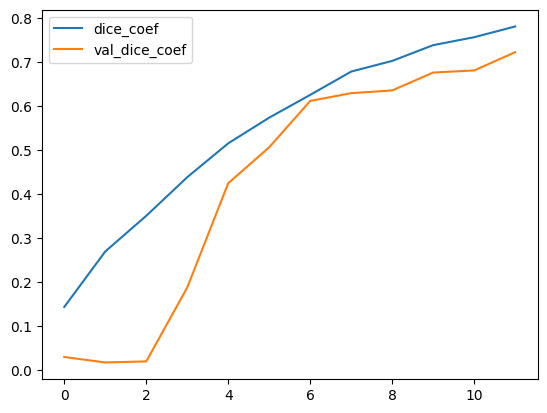

In [21]:
metrics[['dice_coef','val_dice_coef']].plot()

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read and process the image
def plot_mask(path):
  image = cv2.imread(path, cv2.IMREAD_COLOR)  # [H, W, 3] in BGR
  image = cv2.resize(image, (W, H))                  # Resize to (W, H)
  x = image / 255.0                                  # Normalize
  x = np.expand_dims(x, axis=0)                      # [1, H, W]

  # Predict mask
  y_pred = model.predict(x, verbose=0)[0]            # [H, W, 1] or [H, W]
  y_pred = np.squeeze(y_pred, axis=-1)               # [H, W]
  y_pred = (y_pred >= 0.5).astype(np.uint8)          # Binary mask

  # Convert grayscale image to 3-channel RGB for visualization
  image_rgb = image

  # Create a red mask to overlay: [H, W, 3], red channel only
  mask_rgb = np.zeros_like(image_rgb)
  mask_rgb[y_pred == 1] = [255, 0, 0]  # Red color where mask is 1

  # Alpha blend the mask and image
  alpha = 0.5
  overlay = cv2.addWeighted(image_rgb, 1.0, mask_rgb, alpha, 0)

  # Show result
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Original Image + Mask")
  plt.imshow(overlay)
  plt.axis("off")


  plt.subplot(1, 2,2)
  plt.title("Image")
  plt.imshow(image, cmap='gray')
  plt.axis("off")

  plt.tight_layout()
  plt.show()

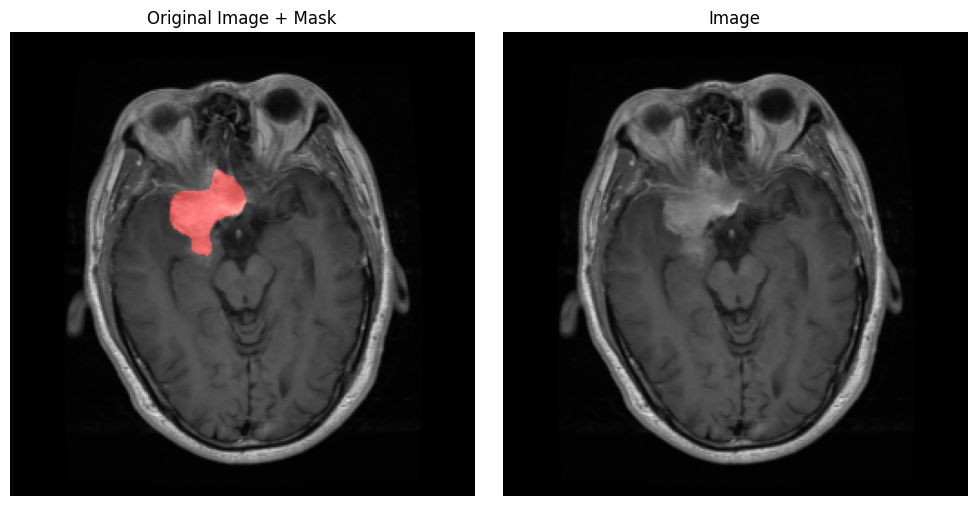

In [27]:
plot_mask("/content/dataset/images/102.png")

DCT(DISCRETE-COSINE-TRANSFORM)

In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import cv2

# Custom Soft Shrinkage layer
class SoftShrinkage(layers.Layer):
    def __init__(self, alpha=0.1, **kwargs):
        super(SoftShrinkage, self).__init__(**kwargs)
        self.alpha = alpha

    def call(self, inputs):
        return tf.sign(inputs) * tf.maximum(tf.abs(inputs) - self.alpha, 0)

    def get_config(self):
        config = super(SoftShrinkage, self).get_config()
        config.update({'alpha': self.alpha})
        return config

# Function to preprocess images
def preprocess_image(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Convert to grayscale if color image
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize
    img = cv2.resize(img, target_size)

    # Normalize
    img = img / 255.0

    # Add channel dimension
    img = np.expand_dims(img, axis=-1)

    return img

In [14]:
def train_brain_tumor_model(data_dir, epochs=50, batch_size=32, img_size=(256, 256)):
    # Check if dataset exists
    if not os.path.exists(data_dir):
        print(f"Dataset directory '{data_dir}' not found!")
        return None

    # Get class information
    classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    num_classes = len(classes)
    print(f"Found {num_classes} classes: {classes}")

    # Setup data generators
    train_generator, validation_generator = setup_data_generators(
        data_dir,
        img_size=img_size,
        batch_size=batch_size
    )

    # Build model
    model = build_brain_tumor_model(
        input_shape=(img_size[0], img_size[1], 1),
        num_classes=num_classes
    )

    # Print model summary
    model.summary()

    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    checkpoint = ModelCheckpoint(
        'brain_tumor_model_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    # Train model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[checkpoint, early_stopping]
    )

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Save final model
    model.save('brain_tumor_final_model.h5')
    print("Model training completed and saved!")

    return model, history



In [15]:
def build_brain_tumor_model(input_shape=(256, 256, 1), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    # Feature extraction layer (7x7 DCT Convolution)
    x = layers.Conv2D(64, kernel_size=7, padding='same', name='feature_extraction')(inputs)
    x = SoftShrinkage(name='soft_shrinkage_1')(x)

    # Feature conversion layer 1 (48 channels with 3x3 Convolution)
    x = layers.Conv2D(48, kernel_size=3, padding='same', name='feature_conversion_1')(x)
    x = SoftShrinkage(name='soft_shrinkage_2')(x)

    # Feature conversion layer 2
    x = layers.Conv2D(48, kernel_size=3, padding='same', name='feature_conversion_2')(x)
    x = SoftShrinkage(name='soft_shrinkage_3')(x)

    # Add classification layers for tumor classification
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(96, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Dropout(0.3)(x)

    # Final classification layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
def evaluate_model(model, test_dir, img_size=(256, 256), batch_size=32):
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns

    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        shuffle=False
    )

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Get predictions
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_indices = test_generator.class_indices
    class_names = {v: k for k, v in class_indices.items()}

    # Create confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names.values(),
                yticklabels=class_names.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Display classification report
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes,
                               target_names=class_names.values()))



In [18]:
def setup_data_generators(data_dir, img_size=(256, 256), batch_size=32):
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2  # 20% for validation
    )

    # Training generator
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        subset='training',
        shuffle=True
    )

    # Validation generator
    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        subset='validation',
        shuffle=False
    )

    return train_generator, validation_generator


In [ ]:
def main():
    # Path to dataset folder
    data_dir = '/content/project/dataset'

    # Train model
    model, _ = train_brain_tumor_model(
        data_dir=data_dir,
        epochs=15,
        batch_size=32,
        img_size=(256, 256)
    )

    print("Brain tumor classification model successfully trained!")

if __name__ == "__main__":
    main()

Found 3 classes: ['glioma', 'meningioma', 'notumor']
Found 3405 images belonging to 3 classes.
Found 850 images belonging to 3 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_extraction (Conv2D)          │ (None, 256, 256, 64)        │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ soft_shrinkage_1 (SoftShrinkage)     │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_conversion_1 (Conv2D)        │ (None, 256, 256, 48)        │          27,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ soft_shrinkage_2 (SoftShrinkage)     │ (None, 256, 256, 48)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_conversion_2 (Conv2D)        │ (None, 256, 256, 48)        │          20,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ soft_shrinkage_3 (SoftShrinkage)     │ (None, 256, 256, 48)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 128, 128, 48)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 96)        │          41,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64, 64, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 393216)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      50,331,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,425,411 (192.36 MB)

 Trainable params: 50,425,411 (192.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.4961 - loss: 0.9681 
Epoch 1: val_accuracy improved from -inf to 0.62380, saving model to brain_tumor_model_best.h5



106/106 ━━━━━━━━━━━━━━━━━━━━ 3107s 29s/step - accuracy: 0.4968 - loss: 0.9675 - val_accuracy: 0.6238 - val_loss: 1.0121
Epoch 2/15
  1/106 ━━━━━━━━━━━━━━━━━━━━ 58:52 34s/step - accuracy: 0.7188 - loss: 0.6916

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.62380 to 0.64062, saving model to brain_tumor_model_best.h5



106/106 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.7188 - loss: 0.6916 - val_accuracy: 0.6406 - val_loss: 0.9499
Epoch 3/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.6726 - loss: 0.7599 
Epoch 3: val_accuracy did not improve from 0.64062
106/106 ━━━━━━━━━━━━━━━━━━━━ 3065s 29s/step - accuracy: 0.6726 - loss: 0.7598 - val_accuracy: 0.5709 - val_loss: 0.9863
Epoch 4/15
  1/106 ━━━━━━━━━━━━━━━━━━━━ 46:54 27s/step - accuracy: 0.7500 - loss: 0.6598
Epoch 4: val_accuracy did not improve from 0.64062
106/106 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.7500 - loss: 0.6598 - val_accuracy: 0.5685 - val_loss: 0.9680
Epoch 5/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.7171 - loss: 0.6516 
Epoch 5: val_accuracy improved from 0.64062 to 0.69591, saving model to brain_tumor_model_best.h5



106/106 ━━━━━━━━━━━━━━━━━━━━ 3150s 29s/step - accuracy: 0.7171 - loss: 0.6513 - val_accuracy: 0.6959 - val_loss: 0.7102
Epoch 6/15
  1/106 ━━━━━━━━━━━━━━━━━━━━ 1:01:58 35s/step - accuracy: 0.7812 - loss: 0.5024
Epoch 6: val_accuracy improved from 0.69591 to 0.71394, saving model to brain_tumor_model_best.h5



106/106 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.7812 - loss: 0.5024 - val_accuracy: 0.7139 - val_loss: 0.6978
Epoch 7/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.7732 - loss: 0.5315 
Epoch 7: val_accuracy did not improve from 0.71394
106/106 ━━━━━━━━━━━━━━━━━━━━ 3048s 29s/step - accuracy: 0.7731 - loss: 0.5315 - val_accuracy: 0.7115 - val_loss: 0.6828
Epoch 8/15
  1/106 ━━━━━━━━━━━━━━━━━━━━ 46:45 27s/step - accuracy: 0.8750 - loss: 0.4368
Epoch 8: val_accuracy did not improve from 0.71394
106/106 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.8750 - loss: 0.4368 - val_accuracy: 0.7103 - val_loss: 0.7171
Epoch 9/15
 21/106 ━━━━━━━━━━━━━━━━━━━━ 37:54 27s/step - accuracy: 0.7677 - loss: 0.5212